In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto
from scipy.interpolate import interp1d
import warnings
import multiprocessing as mp
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

ad_quantiles = np.loadtxt('/kaggle/input/adquantiles/ADQuantiles.csv', delimiter=",",
                          dtype=float, skiprows=1, usecols=range(1, 1000))
ad_pvals = np.round(np.linspace(0.999, 0.001, 1000), 3)  # col names
ad_shape = np.round(np.linspace(-0.5, 1, 151), 2)  # row names


def var_sa(x, alph):
    return np.sort(x)[int(np.floor(alph*len(x)))]


def cvar_sa(x, alph):
    q = var_sa(x, alph)
    y = x[x >= q]
    return np.mean(y), q, y


def get_excesses(x, tp):
    thresh = var_sa(x, tp)
    excesses = x[x > thresh] - thresh
    return thresh, excesses


def gpd_fit(y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        xi_mle, _, sig_mle = genpareto.fit(y, floc=0)
    return xi_mle, sig_mle


def gpd_ad(x, tp):
    u, y = get_excesses(x, tp)
    xi, sigma = gpd_fit(y)
    z = genpareto.cdf(y, xi, 0, sigma)
    z = np.sort(z)
    n = len(z)
    i = np.linspace(1, n, n)
    stat = -n - (1/n) * np.sum((2 * i - 1) * (np.log(z) + np.log1p(-z[::-1])))
    return u, stat, xi, sigma


def ad_pvalue(stat, xi):
    row = np.where(ad_shape == max(round(xi, 2), -0.5))[0][0]
    if stat > ad_quantiles[row, -1]:
        xdat = ad_quantiles[row, 950:999]
        ydat = -np.log(ad_pvals[950:999])
        lfit = np.polyfit(xdat, ydat, 1)
        m = lfit[0]
        b = lfit[1]
        p = np.exp(-(m*stat+b))
    else:
        bound_idx = min(np.where(stat < ad_quantiles[row, ])[0])
        bound = ad_pvals[bound_idx]
        if bound == 0.999:
            p = bound
        else:
            x1 = ad_quantiles[row, bound_idx-1]
            x2 = ad_quantiles[row, bound_idx]
            y1 = -np.log(ad_pvals[bound_idx-1])
            y2 = -np.log(ad_pvals[bound_idx])
            lfit = interp1d([x1, x2], [y1, y2])
            p = np.exp(-lfit(stat))
    return p


def forward_stop(pvals, signif):
    pvals_transformed = np.cumsum(-np.log(1-pvals))/np.arange(1,len(pvals)+1)
    kf = np.where(pvals_transformed <= signif)[0]
    if len(kf) == 0:
        stop = 0
    else:
        stop = max(kf) + 1
    if stop == pvals.size:
        stop -= 1
    return kf, stop


def cvar_evt(alph, u, xi, sigma, tp):
    s = (1-tp)/(1-alph)
    if xi == 0:
        return u + sigma * (np.log(s) + 1)
    else:
        return u + (sigma/(1-xi)) * (1+((s**xi) - 1)/xi)


def cvar_ad(x, alph, tp_start=0.79, tp_end=0.98, tp_num=20, signif=0.1, cutoff=0.9):
    tps = np.linspace(tp_start, tp_end, tp_num)
    ad_tests = []
    pvals = []
    n_rejected = 0
    
    for tp in tps:
        u, stat, xi, sigma = gpd_ad(x, tp)
        if xi <= cutoff:
            ad_tests.append([u, xi, sigma, tp])
            pvals.append(ad_pvalue(stat, xi))
        else:
             n_rejected += 1

    if len(ad_tests) == 0:
        return cvar_sa(x, alph)[0], np.nan, n_rejected, xi, sigma, u

    ad_tests = np.asarray(ad_tests)
    pvals = np.asarray(pvals)

    kf, stop = forward_stop(pvals, signif)

    params = ad_tests[stop]
    tp = params[-1]
    sigma = params[-2]
    xi = params[-3]
    u = params[-4]
    cvar = cvar_evt(alph, *params)

    return cvar, tp, n_rejected , xi, sigma, u

def cvar_ad_same(x, alph, t):
    #print('t', t)
    if pd.isnull(t) == True:
        #print('Yes')
        #print('cvar_sa(x, alph)', cvar_sa(x, alph)[0])
        return [cvar_sa(x, alph)[0]]
    
    else:
        ad_tests1 = []
        u1, stat1, xi1, sigma1 = gpd_ad(x, t)
        ad_tests1.append([u1, xi1, sigma1, t])
        ad_tests1 = np.asarray(ad_tests1)
        params1 = ad_tests1[0]
        tp3 = params1[-1]
        sigma3 = params1[-2]
        xi3 = params1[-3]
        u3 = params1[-4]
        cvar3 = cvar_evt(alph, *params1)
        
        return cvar3, tp3 , xi3, sigma3, u3


def cvar_iter(x, alph, sampsizes, cvar_fn):
    cvars = []
    for n in sampsizes:
        c = cvar_fn(x[:n], alph)
        cvars.append(c)
    return np.array(cvars)

def cvar_iter_sa(x, alph, sampsizes, cvar_fn):
    cvars2 = []
    for n in sampsizes:
        c2 = cvar_fn(x[:n], alph)
        cvars2.append(c2)
    return cvars2

def cvar_iter_same(x, alph, sampsizes, cvar_fn, t):
    cvars3 = []
    for n, m in zip(sampsizes, range(len(sampsizes))):
        c3 = cvar_fn(x[:n], alph, t[m])
        cvars3.append(c3)
    return np.array(cvars3)


# generate CVaR estimates from sample data
def get_cvars_evt(dist_data, alph, sampsizes):
    n_cpus = mp.cpu_count()
    pool = mp.Pool(n_cpus)
    cvars_evt = [] # extreme value theory estimates
    tp = [] # threshold percentiles chosen
    n_rejected = [] # rejection rate from mle estimation
    xi = [] # xi from mle estimation for y (excesses data)
    sigma = [] # sigma from mle estimation for y (excesses data)
    u = []

    for d in dist_data:
        # evt cvar
        result1 = [pool.apply_async(cvar_iter, args=(x, alph, sampsizes, cvar_ad)) for x in d]

        # evt cvar
        c_est1 = np.array([r.get() for r in result1])
        #print('c_est1', c_est1)
        cvars_evt.append(c_est1[:,:,0])
        tp.append(c_est1[:,:,1])
        n_rejected.append(c_est1[:,:,2])
        xi.append(c_est1[:,:,3])
        sigma.append(c_est1[:,:,4])
        u.append(c_est1[:,:,5])

    return np.array([cvars_evt, tp, n_rejected, xi, sigma, u])


def get_cvars_evt_sameu(dist_data, alph, sampsizes, tp_selected):
    n_cpus = mp.cpu_count()
    pool = mp.Pool(n_cpus)
    cvars_evt_same = [] # extreme value theory estimates
    xi4 = [] # xi from mle estimation for y (excesses data)
    sigma4 = [] # sigma from mle estimation for y (excesses data)
    u4 = []
    tp4 = []
    for d , tps_c in zip(dist_data, tp_selected):
        # evt cvar
        result3 = [pool.apply_async(cvar_iter_same, args=(x, alph, sampsizes, cvar_ad_same, t)) for x,t in zip(d,tps_c)]

        # evt cvar
        c_est3 = np.array([r.get() for r in result3])
        #print('c_est3', c_est3)
        cvars_evt_same.append(c_est3[:,:,0])
        #tp4.append(c_est3[:,:,1])
        #xi4.append(c_est3[:,:,2])
        #sigma4.append(c_est3[:,:,3])
        #u4.append(c_est3[:,:,4])

    return np.array([cvars_evt_same]) #tp4, xi4, sigma4, u4])


def get_cvars_sa(dist_data, alph, sampsizes):
    n_cpus1 = mp.cpu_count()
    pool1 = mp.Pool(n_cpus1)
    cvars_sa = [] # sample average estimates
    sa_q = []
    sa_y = []
    for d in dist_data:
        # sa cvar
        result2 = [pool1.apply_async(cvar_iter_sa, args=(x, alph, sampsizes, cvar_sa)) for x in d]

        # sa cvar
        c_est2 = np.array([r.get() for r in result2])
    
        cvars_sa.append(c_est2[:,:,0])
        sa_q.append(c_est2[:,:,1])
        sa_y.append(c_est2[:,:,2])

    return np.array([cvars_sa]), np.array([sa_q]), np.asarray([sa_y])



def cvar_evt_each_epochs(shape, theta, seed):
    
    #print('theta for evt', theta)
    scale1 = ((theta-0.4)**2) +2
    #print('scale1 for evt', scale1)
    np.random.seed(seed)
    pareto_data1 = np.array([genpareto.rvs(shape, loc=0, scale=scale1, size=(1, 2000))])
    
    scale2 = (( (theta+eps) -0.4) **2) +2
    #print('scale2 for evt', scale2)
    #print('seed for data2', seed)
    np.random.seed(seed)
    pareto_data2 = np.array([genpareto.rvs(shape, loc=0, scale=scale2, size=(1, 2000))])
    #print('pareto_data1 evt', pareto_data1)
    pareto_result_evt = get_cvars_evt(pareto_data1, alph, sampsizes)
    tp_selected = pareto_result_evt[1] #tp
    #print('tp_selected', tp_selected)
    shape_estimate = pareto_result_evt[3]
    sigma_estimate = pareto_result_evt[4]
    u_estimate = pareto_result_evt[5]
    pareto_result_evt_sameu = get_cvars_evt_sameu(pareto_data2, alph, sampsizes, tp_selected)
    #shape_estimate_eps = pareto_result_evt_sameu[2]
    #sigma_estimate_eps = pareto_result_evt_sameu[3]
    #u_estimate_eps = pareto_result_evt_sameu[4]

    return pareto_result_evt, pareto_result_evt_sameu, shape_estimate, sigma_estimate, u_estimate, tp_selected #shape_estimate_eps, sigma_estimate_eps, , u_estimate_eps, pareto_data1,pareto_data2,      #, pareto_cvars_true1, pareto_cvars_true2

def cvar_sa_each_epochs(shape, theta, seed):
    #print('theta for sa', theta)
    
    scale1 = ((theta-0.4)**2) +2
    #print('scale1 for sa', scale1)
    np.random.seed(seed)
    
    pareto_data1 = np.array([genpareto.rvs(shape, loc=0, scale=scale1, size=(1, 2000))])
    #print('pareto_data1 sa', pareto_data1)
    scale2 = (( (theta+eps) -0.4) **2) +2
    #print('scale2 for sa', scale2)
    np.random.seed(seed)
    pareto_data2 = np.array([genpareto.rvs(shape, loc=0, scale=scale2, size=(1, 2000))])
        
    pareto_result_sa1 = get_cvars_sa(pareto_data1,alph,sampsizes)
    
    pareto_result_sa2 = get_cvars_sa(pareto_data2,alph,sampsizes)
    
    cvar_sa1 = pareto_result_sa1[0]
    q1 = pareto_result_sa1[1]
    y1 = pareto_result_sa1[2]
    #print('cvar_sa1', cvar_sa1)
    #print('q1', q1)
    #print('y1', y1)
    
    cvar_sa2 = pareto_result_sa2[0]
    q2 = pareto_result_sa2[1]
    y2 = pareto_result_sa2[2]
    
    
    
    return cvar_sa1,cvar_sa2, pareto_data1, pareto_data2, q1,q2,y1,y2 #, pareto_cvars_sa_true1, pareto_cvars_sa_true2


        
def cvar_true(alph,shape,sigma):
    if shape == 0:
        return sigma * (1 - np.ln(1-alph))
    else:  
        return sigma * ( ((1-alph)**(-shape))/(1-shape) + (((1-alph)**(-shape))-1)/shape)
    
def cvar_derivative_true(alph,shape, theta):
    if shape == 0:
        return 2 * (theta-0.4) * (1 - np.ln(1-alph))
    else:  
        return  2 * (theta-0.4) * (((1-alph)**(-shape))/(1-shape) + (((1-alph)**(-shape))-1)/shape)

    
    
def get_derivative(output1, output2):
    
    derivative = (output2 - output1)/eps
    
    return derivative
    

In [ ]:
def cvar_evt_each_epochs(shape, theta, seed):
    
    scale1 = ((theta-0.4)**2) +2 # Based on our assumption
    
    np.random.seed(seed)
    pareto_data1 = np.array([genpareto.rvs(shape, loc=0, scale=scale1, size=(1, 2000))])
    
    scale2 = (( (theta+eps) -0.4) **2) +2

    np.random.seed(seed)
    pareto_data2 = np.array([genpareto.rvs(shape, loc=0, scale=scale2, size=(1, 2000))])

    pareto_result_evt = get_cvars_evt(pareto_data1, alph, sampsizes)
    pareto_result_evt_sameu = get_cvars_evt_sameu(pareto_data2, alph, sampsizes, tp_selected)

    return pareto_result_evt, pareto_result_evt_sameu


def cvar_sa_each_epochs(shape, theta, seed):
    
    scale1 = ((theta-0.4)**2) +2
    np.random.seed(seed)
    
    pareto_data1 = np.array([genpareto.rvs(shape, loc=0, scale=scale1, size=(1, 2000))])

    scale2 = (( (theta+eps) -0.4) **2) +2

    np.random.seed(seed)
    pareto_data2 = np.array([genpareto.rvs(shape, loc=0, scale=scale2, size=(1, 2000))])
        
    pareto_result_sa1 = get_cvars_sa(pareto_data1,alph,sampsizes)
    
    pareto_result_sa2 = get_cvars_sa(pareto_data2,alph,sampsizes)
    
    cvar_sa1 = pareto_result_sa1[0]
    cvar_sa2 = pareto_result_sa2[0]
       
    return cvar_sa1,cvar_sa2


def cvar_true(alph,shape,sigma):
    if shape == 0:
        return sigma * (1 - np.ln(1-alph))
    else:  
        return sigma * ( ((1-alph)**(-shape))/(1-shape) + (((1-alph)**(-shape))-1)/shape)
    
def cvar_derivative_true(alph,shape, theta):
    if shape == 0:
        return 2 * (theta-0.4) * (1 - np.ln(1-alph))
    else:  
        return  2 * (theta-0.4) * (((1-alph)**(-shape))/(1-shape) + (((1-alph)**(-shape))-1)/shape)

Path EVT number 0 
Path EVT number 1 
Path EVT number 2 
Path EVT number 3 
Path EVT number 4 
Path SA number 0 
Path SA number 1 
Path SA number 2 
Path SA number 3 
Path SA number 4 
True_cvars [95.09370283178592]
sigma_reshape_evt1 [[[4.88086171 5.12272755]
  [5.12755406 4.10782423]
  [4.27177228 4.36619287]
  [4.09011142 4.44897386]
  [4.30149971 4.63012756]]]
u_reshape_evt [[[5.44017235 5.00219144]
  [5.19948527 5.23729582]
  [5.12296287 4.89258277]
  [5.24777345 5.22542607]
  [5.0885142  5.06261895]]]
shp * u_reshape_evt [[[2.17606894 2.00087658]
  [2.07979411 2.09491833]
  [2.04918515 1.95703311]
  [2.09910938 2.09017043]
  [2.03540568 2.02504758]]]
scale_mean [[[2.70479277 3.12185098]
  [3.04775995 2.0129059 ]
  [2.22258713 2.40915976]
  [1.99100204 2.35880343]
  [2.26609403 2.60507998]]]


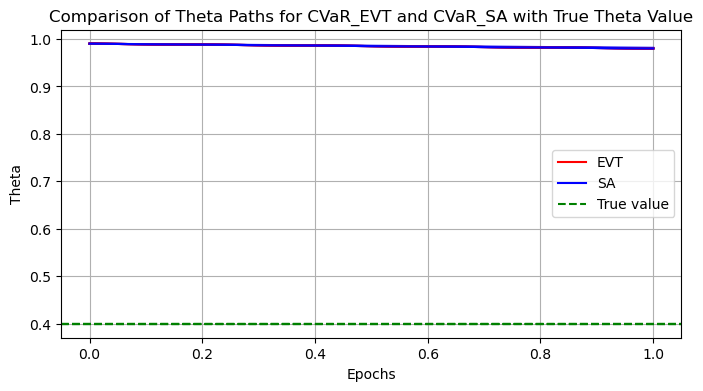

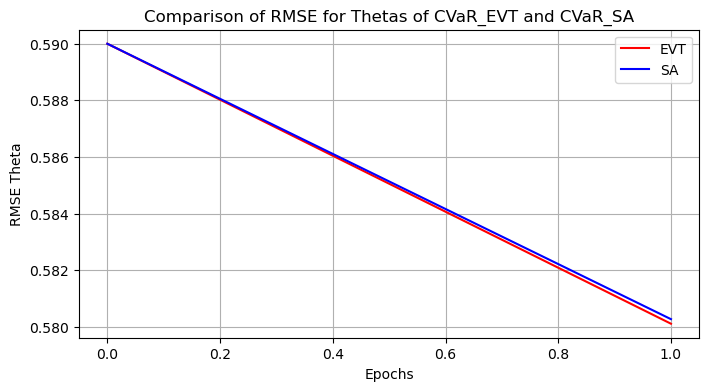

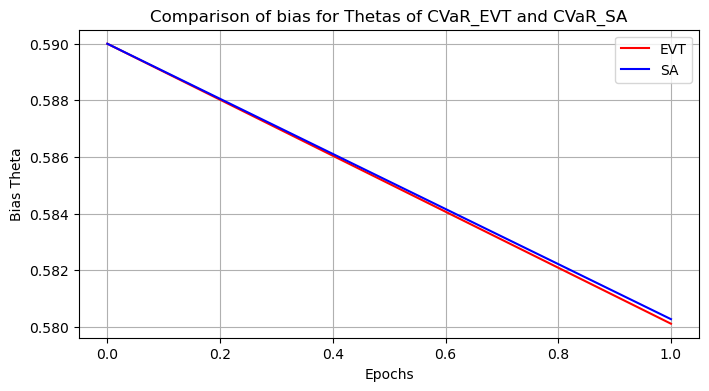

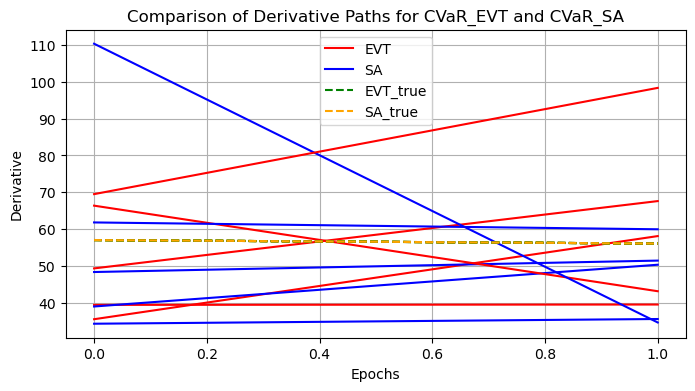

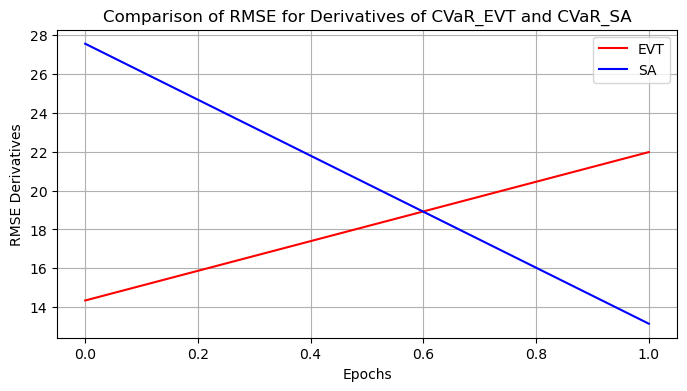

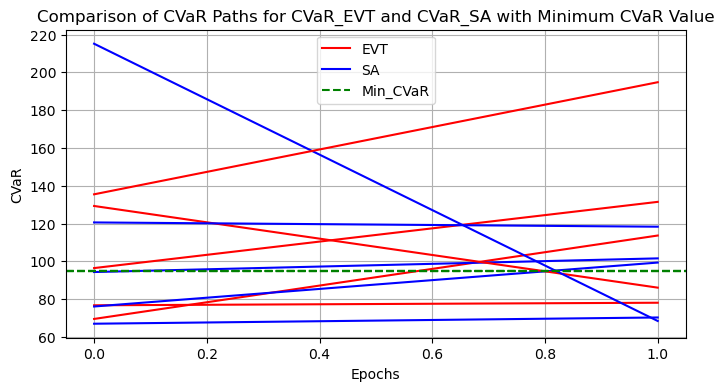

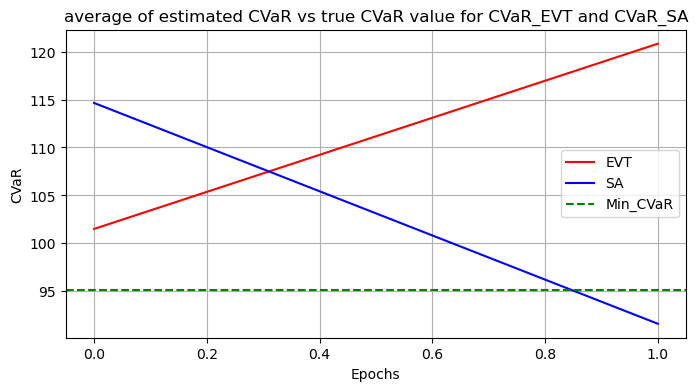

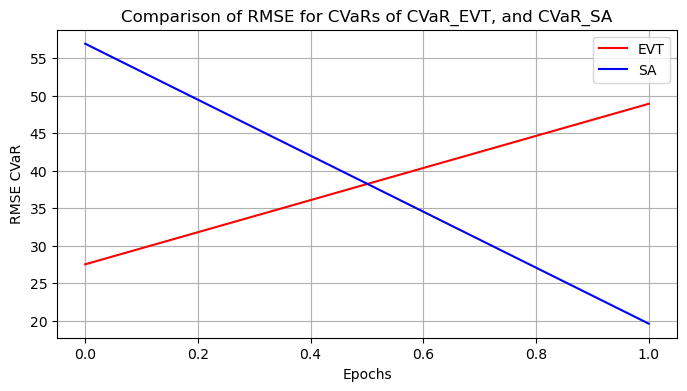

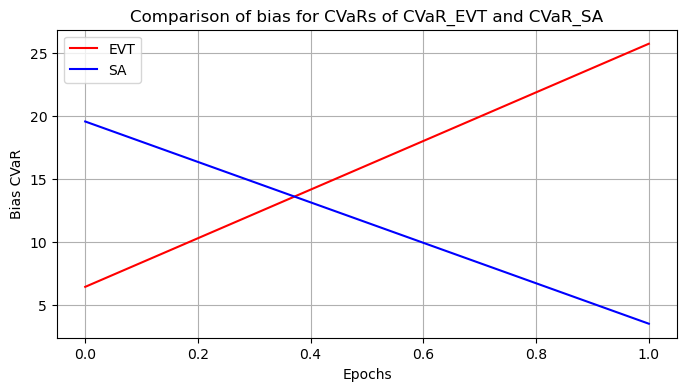

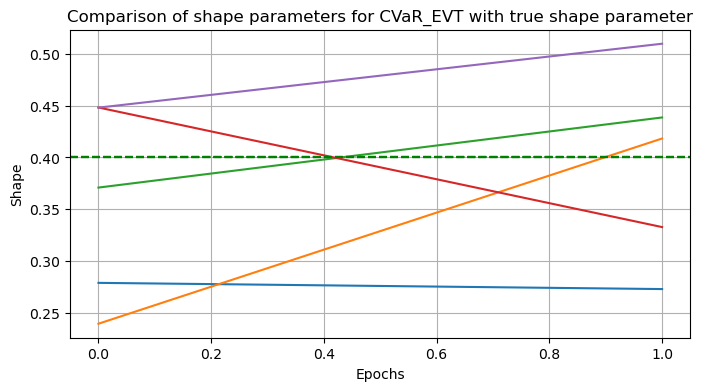

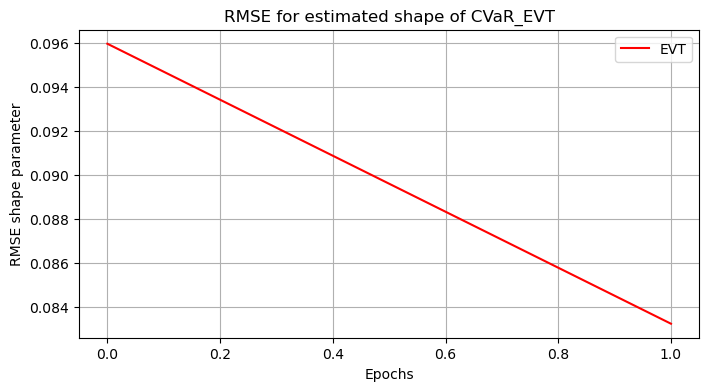

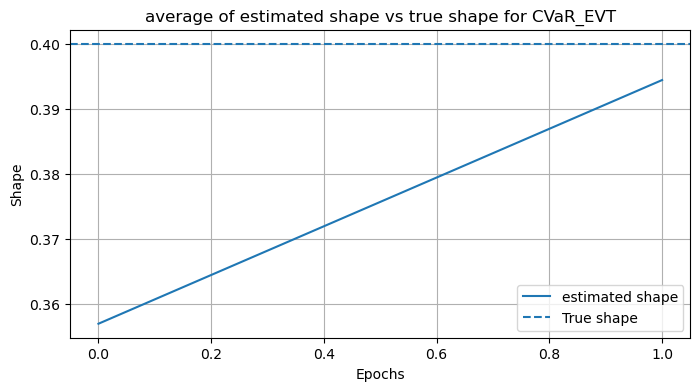

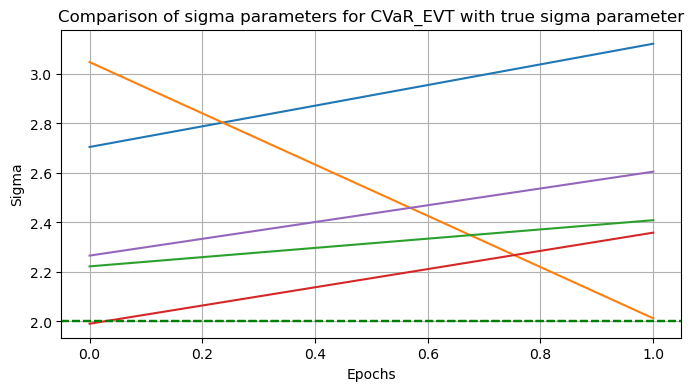

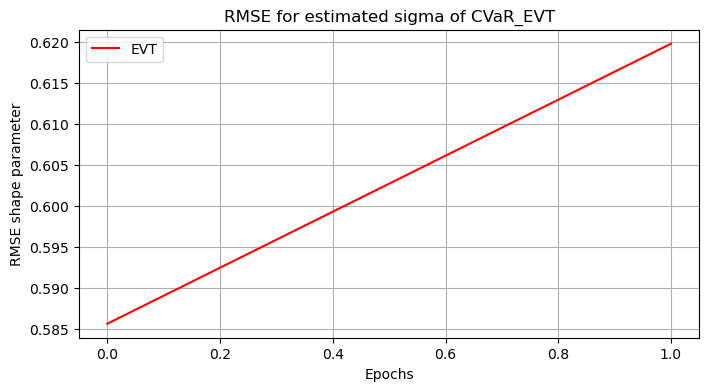

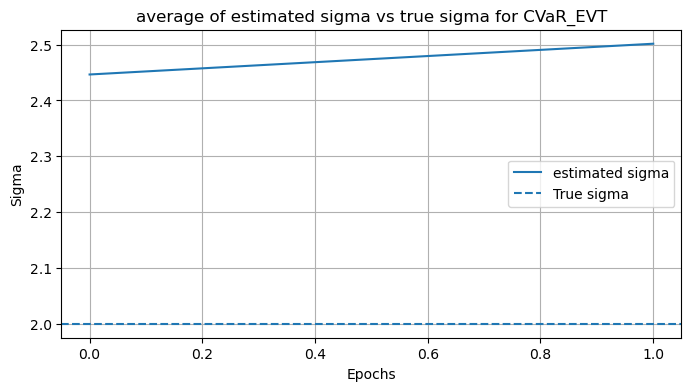

In [4]:
# GPD Shape parameter:

shp = 0.4

eps = 0.01 # used in finite difference
n_paths = range(50)  # Number of episodes
n_seeds = range(50)
n_iter = 500
alph = 0.998
sampsizes = np.linspace(2000, 3000, 1).astype(int) # Number of data generated in each episode

# Optimal CVaR and policy
True_cvars = [95.09370283178592]
True_k = [0.4]
n_iter = 500


# evt 
cvar_evt11 = []
cvar_evt22 = []
tt_evt = []

for j in n_paths:
    m=0
    v=0
    step_size=0.01
    beta1=0.9
    beta2=0.999
    epsilon=1e-8
    initail_theta = 1
    theta_current_evt = initail_theta
    starting_seed = j * n_iter
    print('Path EVT number {} '.format(j))
    tt_evt_each_path = []
    
    cvar_evt11_each_path = []
    cvar_evt22_each_path = []

    for i in range(1, n_iter):
        
        seed_value = starting_seed + i
        
        pareto_result_evt_f = cvar_evt_each_epochs(shape= shp, theta= theta_current_evt, seed=seed_value) 

        EVT1 = pareto_result_evt_f[0] 
        EVT2 = pareto_result_evt_f[1] 
        
        g_evt = get_derivative(EVT1[0], EVT2[0]) 
        derivative_truee_evt = cvar_derivative_true(alph=0.998,shape=shp, theta= theta_current_evt)
        
        g = g_evt[0][0][0]

        m = beta1*m + (1 - beta1)*g
        v = beta2*v + (1 - beta2)*(g**2)

        # assign bias corrected values to m_hat and v_hat respectively
        m_hat = m/(1-beta1**i)
        v_hat = v/(1-beta2**i)

        theta_current_evt = theta_current_evt - step_size*(m_hat/(np.sqrt(v_hat) + epsilon))
        tt_evt_each_path.append(theta_current_evt)
        
        cvar_evt11_each_path.append(EVT1[0][0])
        cvar_evt22_each_path.append(EVT2[0][0])    
    
    tt_evt.append(tt_evt_each_path)
    cvar_evt11.append(cvar_evt11_each_path)
    cvar_evt22.append(cvar_evt22_each_path)
    
    
# sa
cvar_sa11 = []
cvar_sa22 = []
tt_sa = []

for j in n_paths:
    m=0
    v=0
    step_size=0.01
    beta1=0.9
    beta2=0.999
    epsilon=1e-8
    initail_theta = 1
    theta_current_sa = initail_theta
    
    starting_seed = j * n_iter
    print('Path SA number {} '.format(j))
    
    tt_sa_each_path = []
    cvar_sa11_each_path = []
    cvar_sa22_each_path = []
    
    for i in range(1, n_iter):
        
        seed_value = starting_seed + i
        pareto_result_sa_f = cvar_sa_each_epochs(shape= shp, theta= theta_current_sa, seed=seed_value) # output = pareto_result_evt, pareto_result_evt_sameu, pareto_cvars_sa_true1, pareto_cvars_sa_true2
       
        SA1 = pareto_result_sa_f[0]
        SA2 = pareto_result_sa_f[1] 

        g_sa =  get_derivative(SA1, SA2)
        derivative_truee_sa = cvar_derivative_true(alph=0.998, shape=shp, theta= theta_current_sa)
        
        g = g_sa[0][0][0][0]

        # calculate m and v
        m = beta1*m + (1 - beta1)*g
        v = beta2*v + (1 - beta2)*(g**2)

        # assign bias corrected values to m_hat and v_hat respectively
        m_hat = m/(1-beta1**i)
        v_hat = v/(1-beta2**i)

        theta_current_sa = theta_current_sa - step_size*(m_hat/(np.sqrt(v_hat) + epsilon))
        tt_sa_each_path.append(theta_current_sa)
        
        cvar_sa11_each_path.append(SA1[0][0])
        cvar_sa22_each_path.append(SA2[0][0])
    
    tt_sa.append(tt_sa_each_path)    
    cvar_sa11.append(cvar_sa11_each_path)
    cvar_sa22.append(cvar_sa22_each_path)
    

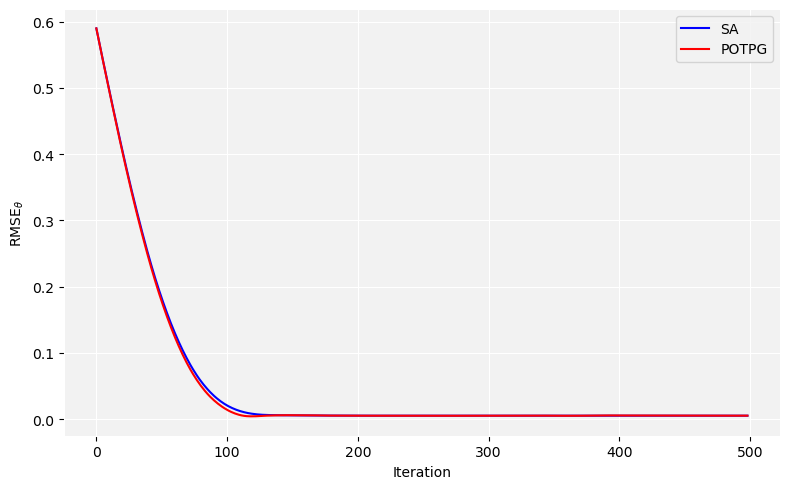

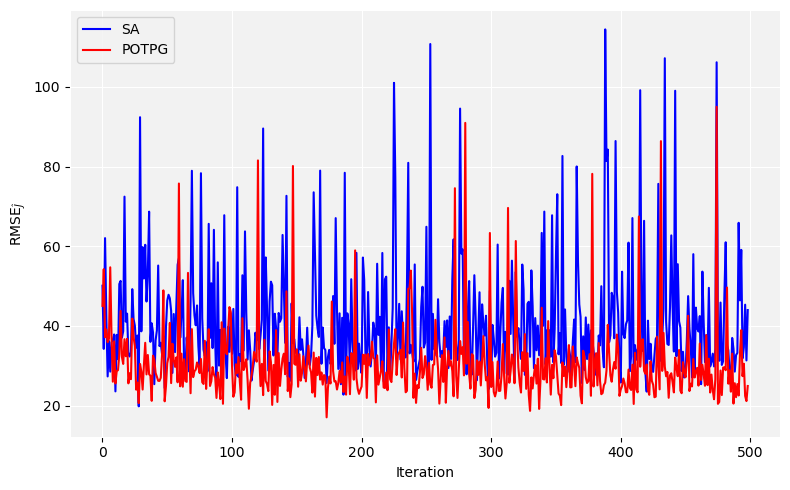

In [3]:

def rmse(x, true): 
    return np.sqrt( (np.mean((x-true)**2, axis=0).astype(float)) )


def cvar_rmse(cvars, cvars_true):
    r = rmse(cvars[0], cvars_true[0])
    return r


# RMSE
rmse_cvar_evt = cvar_rmse(cvar_reshape_evt, True_cvars)
rmse_cvar_sa1 = cvar_rmse(cvar_reshape_sa1, True_cvars)
rmse_k_evt = cvar_rmse(tt_reshape_evt, True_k)
rmse_k_sa = cvar_rmse(tt_reshape_sa, True_k)


plt.rcParams.update({
    'axes.facecolor': '#f2f2f2',
    'axes.edgecolor': 'white',
    'axes.grid': True,
    'grid.color': 'white'
})

# Plot RMSE K 
plt.figure(figsize=(8, 5))
plt.plot(range(n_iter-1), rmse_k_sa, label='SA', color='blue', linestyle='-')
plt.plot(range(n_iter-1), rmse_k_evt, label='POTPG', color='red', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE$_{θ}$')
plt.legend()
plt.tight_layout()
plt.savefig('rmse_k_comparison.pdf') 
plt.show()

# Plot RMSE cvars 
plt.figure(figsize=(8, 5))
plt.plot(range(n_iter-1), rmse_cvar_sa1, label='SA', color='blue', linestyle='-')
plt.plot(range(n_iter-1), rmse_cvar_evt, label='POTPG', color='red', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE$_{\widehat{J}}$')
plt.legend()
plt.tight_layout()
plt.savefig('rmse_cvar_comparison.pdf')
plt.show()

